# **Linear Regression and Regularization with Mathematical Insights: PySpark ML on Diabetes Data**

# **Step 1:** Import the required libraries and initialize SparkSession.

In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegressionExample") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark

# **Step 2:** Load and preprocess the data.

# Data Description

Diabetes Data: https://drive.google.com/file/d/1JgxAN-lTKXbrsaHtetOpybk4XTLRYqCF/view?usp=sharing (204 MB)

We have a dataset of diabetes patients, including ten health measurement features and one variable indicating disease progression after one year.

| Feature 	| Description                           	|
|---------	|---------------------------------------	|
| age     	| Age in years                          	|
| sex     	| Sex                                   	|
| bmi     	| Body Mass Index                       	|
| bp      	| Average blood pressure                	|
| tc      	| T-Cells (a type of white blood cells) 	|
| ldl     	| low-density lipoproteins              	|
| hdl     	| high-density lipoproteins             	|
| tch     	| thyroid stimulating hormone           	|
| ltg     	| lamotrigine                           	|
| glu     	| blood sugar level                     	|

In [16]:
# Load the data from a CSV file
df = spark.read.csv("/Volumes/Portia's Drive/Machine Learning on Big Data/Linear Regression Pyspark/Diabetes.csv", header=True, inferSchema=True)

# get familiar with data
df.show()

# more info
print(df.count())
print(df.rdd.getNumPartitions())

+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
| id|age|   sex|  bmi|    bp|    tc|  ldl|  hdl| tch|  ltg|   glu|progression|
+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
|  0| 22|  Male|20.33|106.25|140.89|-0.45|62.83|0.77|-0.54|130.98|      29.83|
|  1| 41|Female|25.99|132.23|129.64|-1.11|37.26|0.81| 1.64|151.19|      46.66|
|  2| 51|Female|32.76| 127.0|220.36|-1.69|49.56|0.41|-0.88|176.22|      59.97|
|  3| 26|  Male|35.87| 138.4|194.19|-0.04|55.57|0.45|-1.38|125.32|      42.44|
|  4| 42|Female| 21.5|122.33|275.79| 1.19|63.64|0.54|-0.69|184.72|      49.36|
|  5| 47|  Male|31.62|137.18|232.35|-1.65|36.68|0.26| 1.63| 99.83|      54.15|
|  6| 22|  Male|37.06|106.47|244.34|-0.07|34.22|0.48|-1.72| 65.41|      39.55|
|  7| 23|  Male|26.75|129.39|177.69|-0.37|42.03|0.68| 0.82|180.71|      33.12|
|  8| 44|Female|28.38|125.23|276.99| 0.69|55.18| 1.1|-0.52|134.71|      53.84|
|  9| 36|  Male|36.83| 121.9|174.81|  1.1|53.55|0.25

3045570
4


In [17]:
# Repartition Data
df = df.repartition(4)
df.rdd.getNumPartitions()

4

# StringIndexer

In [18]:
# Map a string column of labels (categorical column) to a column of label indices
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'sex', outputCol = 'gender')

df = indexer.fit(df).transform(df)

df.show(10)

+------+---+------+-----+------+------+-----+-----+----+-----+------+-----------+------+
|    id|age|   sex|  bmi|    bp|    tc|  ldl|  hdl| tch|  ltg|   glu|progression|gender|
+------+---+------+-----+------+------+-----+-----+----+-----+------+-----------+------+
|757681| 46|  Male| 37.4|112.62|156.98| 0.81| 59.1| 0.6|-1.42|  80.0|      60.81|   1.0|
|667043| 34|Female|19.03|116.07|374.63| 0.29|55.56|0.28|-0.14|161.07|      39.95|   0.0|
|604868| 46|Female|31.91|123.53| 216.7|-1.09|38.98|0.24| 0.44| 106.9|      54.82|   0.0|
|378993| 32|Female|31.33|120.34|108.78| -0.4|43.18|0.34|-0.39| 92.61|      43.95|   0.0|
|462891| 35|Female|38.46|118.59|152.69|  0.8|52.57|0.64|-0.47|151.64|      51.28|   0.0|
|432952| 60|Female|30.65|115.52|215.23|-0.22|39.04|0.84|-0.89|123.68|      67.89|   0.0|
|399623| 17|  Male|37.69|122.55|226.72| 1.51|43.67|0.47|  0.2| 36.07|      35.82|   1.0|
|778844| 56|  Male|34.29| 108.8|223.87|-0.86|42.35|0.59|  0.5|113.61|      64.51|   1.0|
|123132| 20|Female|31

# VectorAssembler

In [19]:
# combine features into a single vector column

assembler = VectorAssembler(inputCols = ["age", "gender", "bmi","bp","tc","ldl","hdl","tch","ltg","glu"],
                            outputCol = 'features')
data = assembler.transform(df)

data = data.select('features', 'progression')
data.show(5, truncate = False)

+------------------------------------------------------------+-----------+
|features                                                    |progression|
+------------------------------------------------------------+-----------+
|[63.0,1.0,30.26,112.29,213.69,-1.13,55.45,0.47,-0.2,108.6]  |68.79      |
|[36.0,1.0,22.73,135.4,191.81,-1.23,47.01,0.58,-0.66,98.06]  |42.56      |
|[54.0,0.0,29.91,123.04,198.83,-0.15,51.1,0.41,0.19,73.99]   |61.74      |
|[29.0,1.0,31.55,120.4,216.46,0.73,33.12,0.56,0.9,98.08]     |41.58      |
|[21.0,1.0,36.62,130.45,230.84,-0.93,59.33,0.42,-0.05,141.33]|36.53      |
+------------------------------------------------------------+-----------+
only showing top 5 rows



# StandardScaler

In [20]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')
#scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaledFeatures')

scaler_model = scaler.fit(data) # compute the mean & std from data and store the necessary scaling parameters.
data = scaler_model.transform(data) # scale the features of the data using parameteres learned during fit() step

data = data.select('scaledFeatures', 'progression')
data.show(5, truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|scaledFeatures                                                                                                                                                                                 |progression|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[6.297985093610998,1.9999996870586678,4.326282213876212,11.230832430844329,4.273963837377312,-1.1288079737012333,5.545692549469529,2.351023466482048,-0.1999045248337045,2.1716766088122528]   |68.79      |
|[3.5988486249205702,1.9999996870586678,3.2497156219896333,13.542209556828944,3.836347061852881,-1.2287024846482453,4.701587137070559,2.9012630011906126,-0.6596849319512248,1.9

In [23]:
# split data
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)
train_data.show(5, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|scaledFeatures                                                                                                                                                                              |progression|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[-0.5998081041534284,0.0,3.5542424268659163,12.855097447113915,3.884948924948145,-1.0688712671330265,3.618451874478044,1.8508057076560804,0.4397899546341499,2.470232149968486]             |7.16       |
|[-0.5998081041534284,1.9999996870586678,4.828108075432905,11.903942255936343,3.848947544877579,0.109883962041713,5.928740384716928,2.1009145870690644,0.2498806560421306,1.6675516796395373

# **Step 3:** Apply linear regression model.

In [24]:
lr = LinearRegression(labelCol = 'progression', featuresCol = 'scaledFeatures', predictionCol = 'prediction')

# Fit the model to the training data
lr_model = lr.fit(train_data) # collect Beta0, Beta1, .....---> Y = B0 + B1X1

# Make prediction on the test data
lr_predictions = lr_model.transform(test_data)

24/02/12 15:26:47 WARN Instrumentation: [09864159] regParam is zero, which might cause numerical instability and overfitting.
24/02/12 15:26:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/02/12 15:27:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [25]:
# To see the difference between the actual and predicted values
lr_predictions.select('prediction', 'progression').show(10, truncate = False) 

+------------------+-----------+
|prediction        |progression|
+------------------+-----------+
|10.954014628277223|10.95      |
|17.121808917376036|17.12      |
|15.839312849491202|15.84      |
|16.984819753800917|16.98      |
|13.751311452180069|13.75      |
|10.848016012805003|10.85      |
|13.509213466333321|13.51      |
|12.303511428644585|12.3       |
|15.43971784345371 |15.44      |
|17.04252065964643 |17.04      |
+------------------+-----------+
only showing top 10 rows



In [26]:
# Access the coefficients and intecept of the model
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(coefficients)
print(intercept)

# Predictor (Regressor): Progression =  2.9654446075967323e-05 + 8.502720630777699 AGE + -3.790026394372246e-06 GENDER + 5.935073073073073 BMI + 2.935073073073073 BP + -1.0000000000000002 TC + 0.0000000000000000 LDL + 0.0000000000000000 HDL + 0.0000000000000000 TCH + 0.0000000000000000 LTG + 0.0000000000000000 GLU

[8.50272246778761,-3.4100540228889645e-06,3.497227024571584,0.09998164650585141,-1.1817352922614147e-06,1.0010573407734684,5.161130921203039e-07,-0.019994225149417316,-0.8003852461713519,9.706798533997519e-07]
5.9993406022967946e-05


# **Step 4:** Apply Lasso and Ridge regression models.
For Lasso regression, you would set elasticNetParam to 1.0, indicating that you want to use L1 regularization. For Ridge regression, you would set elasticNetParam to 0.0, indicating that you want to use L2 regularization.


In [27]:
# Laaso
lasso = LinearRegression(labelCol = 'progression', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 1.0, regParam = 0.15) # lambda: tuning
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

# Ridge
ridge = LinearRegression(labelCol = 'progression', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.15) # lambda: tuning
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

In [28]:
lasso_predictions.select('prediction', 'progression').show(10, truncate = False)

+------------------+-----------+
|prediction        |progression|
+------------------+-----------+
|11.72232681924195 |10.95      |
|17.32693543093627 |17.12      |
|16.41375395960399 |15.84      |
|17.70243160395849 |16.98      |
|14.751271887901591|13.75      |
|11.490460538291451|10.85      |
|13.984598554948107|13.51      |
|12.825287293696569|12.3       |
|15.872139408982882|15.44      |
|17.560937596187987|17.04      |
+------------------+-----------+
only showing top 10 rows



# **Step 5:** Evaluate the models and visualize the results.

In [29]:
evaluator_mse = RegressionEvaluator(labelCol = 'progression', predictionCol = 'prediction', metricName = 'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(lr_predictions)
mse2 = evaluator_mse.evaluate(lasso_predictions)
mse3 = evaluator_mse.evaluate(ridge_predictions)

evaluator_rmse = RegressionEvaluator(labelCol = 'progression', predictionCol = 'prediction', metricName = 'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(lr_predictions)
rmse2 = evaluator_rmse.evaluate(lasso_predictions)
rmse3 = evaluator_rmse.evaluate(ridge_predictions)

evaluator_r2 = RegressionEvaluator(labelCol = 'progression', predictionCol = 'prediction', metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(lr_predictions)
r2_score2 = evaluator_r2.evaluate(lasso_predictions)
r2_score3 = evaluator_r2.evaluate(ridge_predictions)

In [30]:
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mse2, ', RMSE: ', rmse2, ', R^2: ', r2_score2)
print('Ridge - MSE: ', mse3, ', RMSE: ', rmse3, ', R^2: ', r2_score3)

Regression - MSE:  8.337762967307309e-06 , RMSE:  0.002887518479128282 , R^2:  0.9999999030219112
Lasso - MSE:  0.10028255574330854 , RMSE:  0.31667421073290536 , R^2:  0.9988335947389315
Ridge - MSE:  0.02173597171965462 , RMSE:  0.14743124404160274 , R^2:  0.9997471848261114


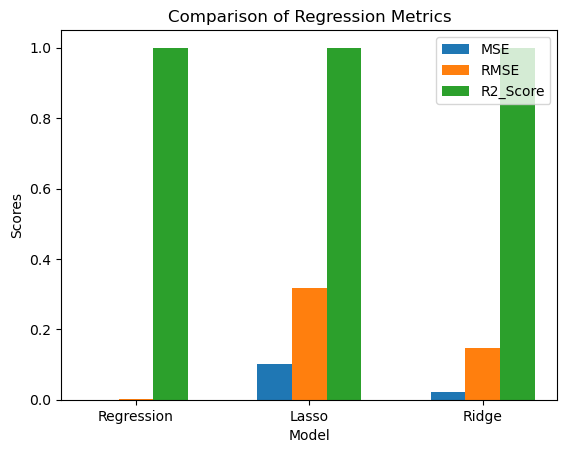

In [31]:
# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mse2, mse3]
rmse = [rmse1, rmse2, rmse3]
r2_score = [r2_score1, r2_score2, r2_score3]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()